## Note:

### Content (Code+Information) compiled from [Sara Safvi](https://twitter.com/sarasomewhere)'s Scipy 2019 [talk](https://www.youtube.com/watch?v=j15MryznWn4) and her [repo notebooks](https://github.com/sarasafavi/remote-sensing-with-python.git) for the study group `Chai-Pe-Charcha` Session-2

--Murali Manohar

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import rasterio
import fiona
from rasterio.plot import show
from rasterio.mask import mask

### Satellite data is commonly available as Vector, Raster form (Already discussed by Asra)

In [4]:
image_file = '20190321_174348_0f1a_3B_AnalyticMS.tif'

In [5]:
satdat = rasterio.open(image_file)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


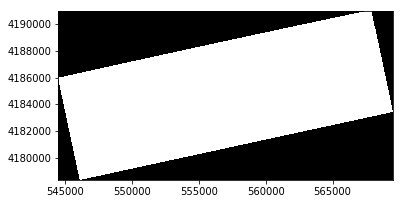

In [6]:
show(satdat)

### Raster file is an image file which has _k_ bands. Here, in this case, it is 4 bands, Red, Green, Blue, Near-Infrared

In [7]:
# Count the no.of bands
satdat.count

4

In [8]:
# Name the band indexes
satdat.indexes

(1, 2, 3, 4)

### Get band data

In [9]:
blue, green, red, nir = satdat.read()

In [11]:
print(blue.shape)
print(green.shape)
print(red.shape)
print(nir.shape)

(4213, 8341)
(4213, 8341)
(4213, 8341)
(4213, 8341)


### These bounds are numpy arrays, which allows you to do all the numpy operations

In [12]:
type(blue)

numpy.ndarray

### This is just like any image. Here, each image covers a particular area. In this data, it is 3meters per pixel

### Know the details of raster file

In [14]:
satdat.meta

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': 0.0,
 'width': 8341,
 'height': 4213,
 'count': 4,
 'crs': CRS.from_epsg(32610),
 'transform': Affine(3.0, 0.0, 544491.0,
        0.0, -3.0, 4191009.0)}

### Bounding boxes of the map -> Gives coordinates of the bounding box in the map space

In [16]:
satdat.bounds

BoundingBox(left=544491.0, bottom=4178370.0, right=569514.0, top=4191009.0)

In [17]:
satdat.width, satdat.height 

(8341, 4213)

### Divide your bbox width by the image width to see how much area does pixel encode 

In [18]:
(satdat.bounds.right - satdat.bounds.left)/ satdat.width
(satdat.bounds.top - satdat.bounds.bottom)/ satdat.height

3.0

In [20]:
(satdat.bounds.right - satdat.bounds.left)/satdat.width

3.0

### It is 3 meters per pixel

### Transforms

In order to translate pixel coordinates in a raster dataset into coordinates that use a spatial reference system, an affine transformation must be applied to the dataset. This transform is a matrix used to translate rows and columns of pixels into (x,y) spatial coordinate pairs. Every spatially referenced raster dataset has an affine transform that describes its pixel-to-map-coordinate transformation.

### What if you want only a part of the image data, like a district/city in a state area?

Area of interest (AOI) polygon. Because this AOI is a vector dataset (versus raster), we'll use Rasterio's sister-library, Fiona, to read the geoJSON dataset:

In [21]:


with fiona.open('aoi.geojson','r') as f:
    aoi = [feature['geometry'] for feature in f]

In [22]:
aoi

[{'type': 'Polygon',
  'coordinates': [[(546021.2526923077, 4185843.2046634606),
    (556143.5374038462, 4186685.3248557686),
    (554543.5090384616, 4180436.7930288455),
    (546408.6279807693, 4179763.0968749993),
    (546021.2526923077, 4185843.2046634606)]]}]

### Now, we want to crop our original raster to get our AOI. We use raster's mask functionality. This creates a copy of the img and gives out a transform.

In [23]:
# If crop=False, all the outside pixels will be 0s/NaNs
with rasterio.open(image_file) as img:
    cropped_img, todotransform = mask(img,aoi,crop=True)

In [25]:
#Use the metadata from original file
meta = img.meta.copy()

#Update the metadata with new details i.e width, height, transform
meta.update({'transform':todotransform,'width':cropped_img.shape[2],'height':cropped_img.shape[1]})

with rasterio.open('cropped_img.tif','w', **meta) as dst:
    dst.write(cropped_img)

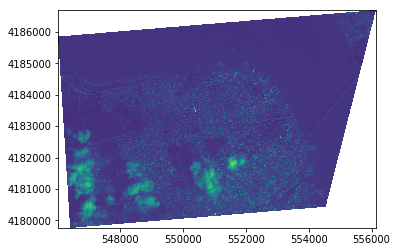

In [26]:
clipped_img = rasterio.open('cropped_img.tif')
show(clipped_img)

### Revisit Transforms

#### Convert pixel coordinates to world coordinates.

In [28]:
clipped_img.width, clipped_img.height

(3375, 2308)

In [19]:
# Upper left pixel
row_min = 0
col_min = 0

# Lower right pixel.  Rows and columns are zero indexing.
row_max = clipped_img.height - 1
col_max = clipped_img.width - 1

# Transform coordinates with the dataset's affine transformation.
topleft = clipped_img.transform * (row_min, col_min)
botright = clipped_img.transform * (row_max, col_max)

print("Top left corner coordinates: {}".format(topleft))
print("Bottom right corner coordinates: {}".format(botright))

Top left corner coordinates: (546021.0, 4186686.0)
Bottom right corner coordinates: (552942.0, 4176564.0)


#### Check them with actual coordinates



In [30]:
clipped_img.bounds

BoundingBox(left=546021.0, bottom=4179762.0, right=556146.0, top=4186686.0)

### Now that you have the graph, you may want to move 10 km away into the area from (top,left). How do you find its pixel equivalent?

In [31]:
import math

# Let's grab the pixel 10km east and 10km south of the upper left corner

# World coordinates for the desired pixel.
x_coord = satdat.bounds.left + 10000
y_coord = satdat.bounds.top - 10000

# Convert world coordinates to pixel.  World coordinates may not transform precisely to row and column indexes,
# but a Numpy array can only be indexed by integer values.  The 'op' parameter for 'satdat.index()' determines
# how the transformed values are rounded.  In some cases any point falling within a pixel should be considered
# contained, and in other cases only points falling within one portion of the pixels hould be considered contained.
# The 'op' parameter lets users make this decision on their own.  The values must still be cast to integers.
col, row = satdat.index(x_coord, y_coord, op=math.floor)
col = int(col)
row = int(row)


# Now let's look at the value of each band at this pixel
print("Red: {}".format(red[row, col]))
print("Green: {}".format(green[row, col]))
print("Blue: {}".format(blue[row, col]))
print("NIR: {}".format(nir[row, col]))

Red: 2771
Green: 3974
Blue: 4603
NIR: 1008


### Let's try visualizing them properly and try to find something useful

In [33]:
# scale values for display purposes
def scale(band):
    return band / 10000.0

# Load the bands into numpy arrays
# recall that we previously learned PlanetScope band order is BGRN
blue = scale(clipped_img.read(1))
green = scale(clipped_img.read(2))
red = scale(clipped_img.read(3))
nir = scale(clipped_img.read(4))

In [35]:
# Use numpy to create two stacks of bands:
import numpy
rgb = numpy.dstack((red, green, blue))
nrg = numpy.dstack((nir, red, green))

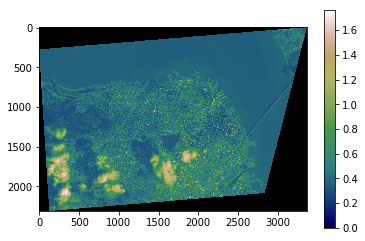

In [36]:
# Plot the green band using a non-default color ramp & a color bar
# see also: https://matplotlib.org/users/colormaps.html
fig = plt.imshow(green)
fig.set_cmap('gist_earth')
plt.colorbar()

# Display the results.
plt.show()

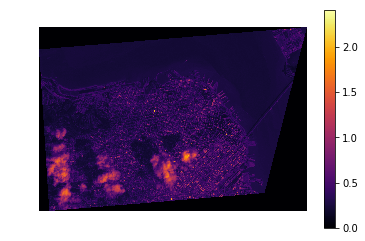

In [37]:
# Plot the red band

fig = plt.imshow(red)
fig.set_cmap('inferno')
plt.colorbar()

# Since the axis labels are useless here, let's turn them off.
plt.axis('off')

# Display the results.
plt.show()

### Displaying the stacked arrays, RGB and InfraRG

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


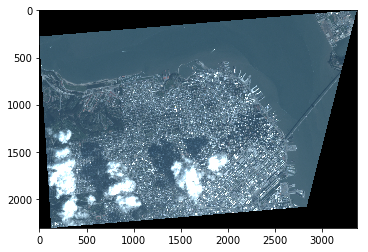

In [38]:
# plot the RGB stack to see a true-color representation
plt.imshow(rgb)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


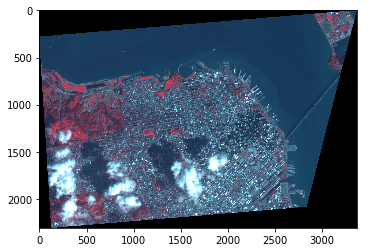

In [39]:
# use the NRG stack to display a false-color composite, highlighting vegetation
# in clipped.tif, the grassy areas and Parks become easy to spot
plt.imshow(nrg)

### NearInfrared band helps in highlighting vegetation(Look at the Red highlighted area). So, the grassy areas and Parks become easy to spot

### Google Earth Engine - 

1. Data repository - LANDSAT, Sentinel 1,2 , MODIS, etc.

### As spatial resolution is getting finer day-by-day, data storage is somewhere in TB. So, what most satellite data providers do is, they run a cloud based offering where you can clip/tile/grid the area of interest and download that specific region

_var filter = imageCollection.filterBounds(geometry).filterDate('2019-01-01','2019-05-01')_

_print(filter.size())_

_Map.addLayer(filter.median().clip(geometry),vis,"L8 guntur")_

_Map.addLayer(filter.median().normalizedDifference(['B5','B3']).clip(geometry))_

### More use cases can be found here - https://gena.users.earthengine.app/

### Different tiling methods. Uber uses what's called as Hexagonal tiling. Walk into another hexagon to get cheaper price.

## Satellite Index database - https://indexdatabase.de to understand different indices required to track different things.

### How does water look like?

Darker, lighter, muddier, turbid etc.
Most classes on earth don't have a standard reflectance that is measured.

### Stratified Sampling

LANDSAT AND JRC WATER HISTORY

#### Another Use case -> Night life https://www.youtube.com/watch?v=ZYGd-llxHJE